# Calibration Approaches

This notebook contrasts three calibration strategies for the photonic kernel-nuller used in PHISE:
- **Trial & Error (genetic-like)**: iterative phase nudging to maximize bright output and symmetries.
- **Obstruction**: phase sweeping under selective input attenuation.
- **Neural calibration (ML)**: supervised prediction of phase corrections from synthetic scans.

The goal is to measure how quickly and how deeply each method converges, using the same VLTI-inspired context.

## How to run
- Use the THESIS virtual environment (`E:/THESIS/.venv`) so that `phise` and PyTorch dependencies are available.
- Set the boolean flags below to skip heavy sections if needed (ML can be time-consuming).
- Plots are generated inline; set `save_dir` to store copies under `generated/plots/`.
- All units follow `astropy.units`; contexts are cloned before perturbations to avoid side effects.

In [1]:
# Imports and notebook setup
import os
import sys
import math
import copy
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u

try:
    import torch
    torch.manual_seed(42)
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 120, "axes.spines.top": False, "axes.spines.right": False})

# Ensure project imports resolve whether the notebook is started at repo root or inside /analysis
ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
SRC = ROOT / "src"
ANALYSIS = SRC / "analysis"
sys.path.append(str(SRC))
sys.path.append(str(ANALYSIS))

from phise import Context
from analysis.calibration import (
    genetic_approach,
    obstruction_approach,
    compare_approaches,
    print_kernel_null_depth,
    print_kernel_null_depth_lab_space_atm,
)
from analysis.neural_calibration import (
    generate_dataset,
    generate_test_dataset,
    preprocess_data,
    train_calibration_model,
    recover_phases,
)

print(f"Working directory: {ROOT}")
print(f"Torch available: {TORCH_AVAILABLE}")

Working directory: e:\THESIS
Torch available: True


In [2]:
# Helper utilities and switches
RUN_GENETIC = True
RUN_OBSTRUCTION = True
RUN_ML = False  # Set to True to run the neural network baseline (can be slow)

save_dir = ROOT / "generated" / "plots"
save_dir.mkdir(parents=True, exist_ok=True)


def build_base_context(monochromatic: bool = True) -> Context:
    """Factory for a clean VLTI context without companions."""
    ctx = Context.get_VLTI()
    ctx.monochromatic = monochromatic
    ctx.target.companions = []
    ctx.Γ = 0 * u.nm
    return ctx


def compute_null_metrics(ctx: Context, samples: int = 200, gamma: u.Quantity = 0 * u.nm) -> dict:
    """Estimate kernel-null depth statistics for a given context."""
    ctx_local = copy.deepcopy(ctx)
    ctx_local.Γ = gamma
    bright = []
    kernels = []
    for _ in range(samples):
        outs = ctx_local.observe()
        k = ctx_local.interferometer.chip.process_outputs(outs)
        bright.append(outs[0])
        kernels.append(k)
    bright = np.array(bright)
    kernels = np.array(kernels)
    depth = kernels / bright[:, None]
    return {
        "gamma": gamma,
        "bright_mean": float(np.mean(bright)),
        "depth_mean": [float(np.mean(depth[:, i])) for i in range(depth.shape[1])],
        "depth_median": [float(np.median(depth[:, i])) for i in range(depth.shape[1])],
        "depth_std": [float(np.std(depth[:, i])) for i in range(depth.shape[1])],
    }


results = []

### Trial & Error (genetic-like)
This follows `Context.calibrate_gen`, which alternates phase shifters between bright-enhancing and kernel-symmetry groups with a decaying step `β`. It roughly emulates a coordinate-descent search over discrete phase nudges.

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 2.69e-06 | -4.51e-07 | 2.01e-06
   Med:  2.69e-06 | -4.50e-07 | 2.01e-06
   Std:  1.98e-09 | 2.42e-09 | 1.55e-09

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 2.63e-06 | -4.44e-07 | 1.96e-06
   Med:  2.52e-06 | -3.81e-07 | 1.92e-06
   Std:  1.02e-06 | 4.46e-07 | 8.95e-07

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: 7.93e-04 | -9.56e-04 | -3.88e-04
   Med:  5.62e-04 | -5.64e-04 | -5.30e-06
   Std:  1.65e-02 | 1.77e-02 | 1.16e-02


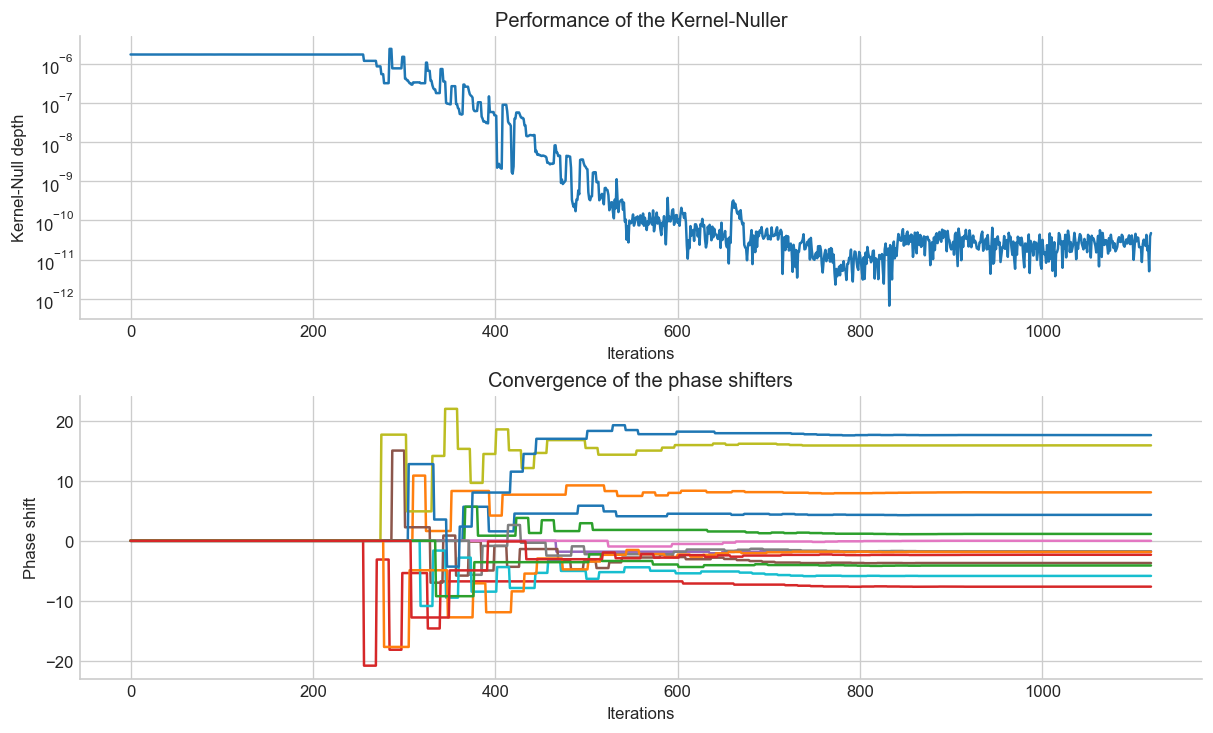

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: 9.36e-13 | 2.86e-12 | -3.95e-11
   Med:  2.26e-13 | 4.63e-12 | -4.47e-11
   Std:  1.93e-11 | 2.25e-11 | 2.87e-11

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 3.25e-09 | 1.59e-09 | -9.82e-10
   Med:  5.95e-10 | -4.36e-10 | -1.65e-10
   Std:  1.95e-08 | 2.71e-08 | 1.39e-08

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: -4.39e-04 | 1.40e-03 | -2.11e-03
   Med:  -5.18e-04 | -4.23e-06 | 5.42e-05
   Std:  2.21e-02 | 2.17e-02 | 1.81e-02


,depth_mean,depth_median,depth_std
K1,1.531267e-12,1.661440e-12,1.791374e-11
K2,5.568890e-12,5.774714e-12,2.287731e-11
K3,-4.321277e-11,-3.863252e-11,3.090854e-11


In [3]:
# Run Trial & Error calibration
ctx_gen = None
if RUN_GENETIC:
    ctx_gen = build_base_context(monochromatic=True)
    ctx_gen = genetic_approach(ctx_gen, β=0.85, verbose=False, figsize=(10, 6), save_as=str(save_dir))
    metrics_gen = compute_null_metrics(ctx_gen, samples=200, gamma=0 * u.nm)
    metrics_gen["method"] = "Trial & Error (genetic)"
    results.append(metrics_gen)
    display(pd.DataFrame({
        "depth_mean": metrics_gen["depth_mean"],
        "depth_median": metrics_gen["depth_median"],
        "depth_std": metrics_gen["depth_std"],
    }, index=["K1", "K2", "K3"]))
else:
    print("Skipped Trial & Error (genetic) calibration.")

### Obstruction approach
This uses `Context.calibrate_obs`, sweeping phase shifters while selectively attenuating inputs to maximize bright paths, dark pairs, then kernel minima. It fits sinusoidal responses to locate optimal phase offsets.

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: -3.07e-07 | 1.04e-06 | 1.36e-06
   Med:  -3.07e-07 | 1.04e-06 | 1.36e-06
   Std:  2.24e-09 | 2.01e-09 | 2.18e-09

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: -3.23e-07 | 8.53e-07 | 1.19e-06
   Med:  -1.72e-07 | 8.83e-07 | 1.04e-06
   Std:  9.48e-07 | 1.02e-06 | 1.06e-06

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: 1.01e-03 | -3.15e-04 | 6.70e-04
   Med:  -6.82e-06 | -1.90e-05 | 2.14e-04
   Std:  1.67e-02 | 1.95e-02 | 1.31e-02


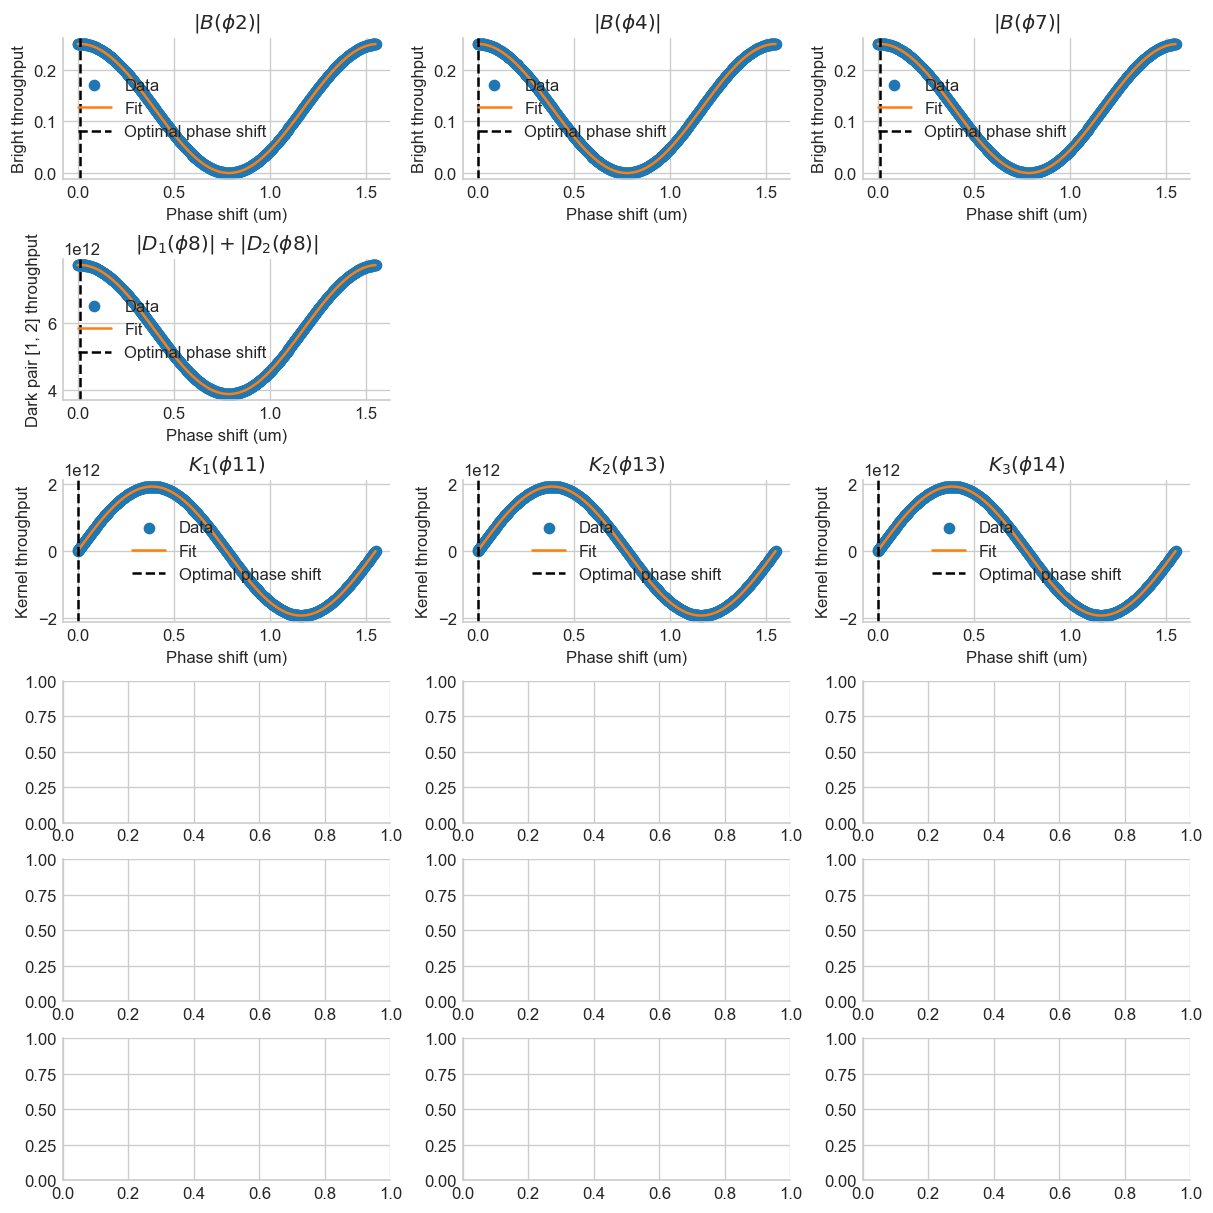

Performances in lab (Γ=0)
Achieved Kernel-Null depth:
   Mean: -7.49e-13 | -5.56e-13 | -1.26e-13
   Med:  6.45e-14 | -9.03e-13 | -2.90e-13
   Std:  1.03e-11 | 1.14e-11 | 4.33e-12

Performances in space (Γ=1 nm)
Achieved Kernel-Null depth:
   Mean: 2.27e-09 | -1.50e-09 | 7.11e-10
   Med:  9.30e-11 | -2.20e-10 | 2.90e-10
   Std:  1.28e-08 | 1.22e-08 | 1.00e-08

Performances in atmosphere (Γ=100 nm)
Achieved Kernel-Null depth:
   Mean: -3.26e-04 | 5.57e-05 | 1.71e-03
   Med:  1.69e-05 | -1.38e-04 | -5.39e-05
   Std:  1.27e-02 | 1.35e-02 | 1.26e-02


,depth_mean,depth_median,depth_std
K1,-2.819609e-13,-8.871768e-13,9.796192e-12
K2,-3.053499e-13,-4.516536e-13,1.061712e-11
K3,-2.563134e-13,-6.452193e-14,4.540211e-12


In [4]:
# Run Obstruction calibration
ctx_obs = None
if RUN_OBSTRUCTION:
    ctx_obs = build_base_context(monochromatic=True)
    ctx_obs = obstruction_approach(ctx_obs, n=600, figsize=(10, 10), save_as=str(save_dir))
    metrics_obs = compute_null_metrics(ctx_obs, samples=200, gamma=0 * u.nm)
    metrics_obs["method"] = "Obstruction"
    results.append(metrics_obs)
    display(pd.DataFrame({
        "depth_mean": metrics_obs["depth_mean"],
        "depth_median": metrics_obs["depth_median"],
        "depth_std": metrics_obs["depth_std"],
    }, index=["K1", "K2", "K3"]))
else:
    print("Skipped Obstruction calibration.")

### Neural calibration (ML)
We train a lightweight version of the PyTorch `CalibrationNet` on synthetic phase/visibility scans produced by `generate_dataset`. The model predicts the phase correction (sin/cos) for each shifter. Set `RUN_ML=True` to execute; defaults are small to keep runtime reasonable.

In [5]:
# Run neural calibration (optional and lightweight)
ml_summary = None
if RUN_ML:
    if not TORCH_AVAILABLE:
        raise ImportError("PyTorch is required for the ML calibration section. Install torch and retry.")

    ctx_ml = build_base_context(monochromatic=True)
    ctx_ml.Γ = 5 * u.nm  # Small piston noise to match training assumptions
    n_shifters = len(ctx_ml.interferometer.chip.φ)
    n_outputs = ctx_ml.interferometer.chip.nb_raw_outputs

    X_train_raw, y_train_raw = generate_dataset(ctx_ml, n_samples=64, n_steps=12)
    X_train, y_train = preprocess_data(X_train_raw, n_shifters, n_outputs, y_train_raw)

    model, loss_history = train_calibration_model(
        X_train,
        y_train,
        n_shifters=n_shifters,
        n_outputs=n_outputs,
        epochs=50,
        learning_rate=5e-4,
        batch_size=16,
        dropout_prob=0.05,
    )

    X_test_raw, y_test_raw = generate_test_dataset(
        ctx_ml,
        test_phases=np.linspace(0, 2 * np.pi, 6),
        n_repeats=3,
        n_steps=12,
    )
    X_test, _ = preprocess_data(X_test_raw, n_shifters, n_outputs)

    model.eval()
    with torch.no_grad():
        pred_proc = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

    pred_phases = recover_phases(pred_proc)
    expected = y_test_raw
    diff = np.abs(pred_phases - expected)
    diff = np.minimum(diff, 2 * np.pi - diff)
    mse = float(np.mean(diff**2))

    ml_summary = {"method": "Neural (ML)", "phase_mse": mse, "epochs": len(loss_history)}
    results.append(ml_summary)
    print(f"Test MSE: {mse:.4f} rad^2 over {pred_phases.size} predictions")

    plt.figure(figsize=(6, 3))
    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training loss (lightweight run)")
    plt.tight_layout()
else:
    print("Skipped neural calibration; set RUN_ML=True to execute.")

Skipped neural calibration; set RUN_ML=True to execute.


### Compare performance
We aggregate kernel-null depths for the physics-based methods and the phase MSE for the neural surrogate (when enabled).

-1.1258459491032764 -5.906565032873997

-1.6580756012069837 -7.213341244825601


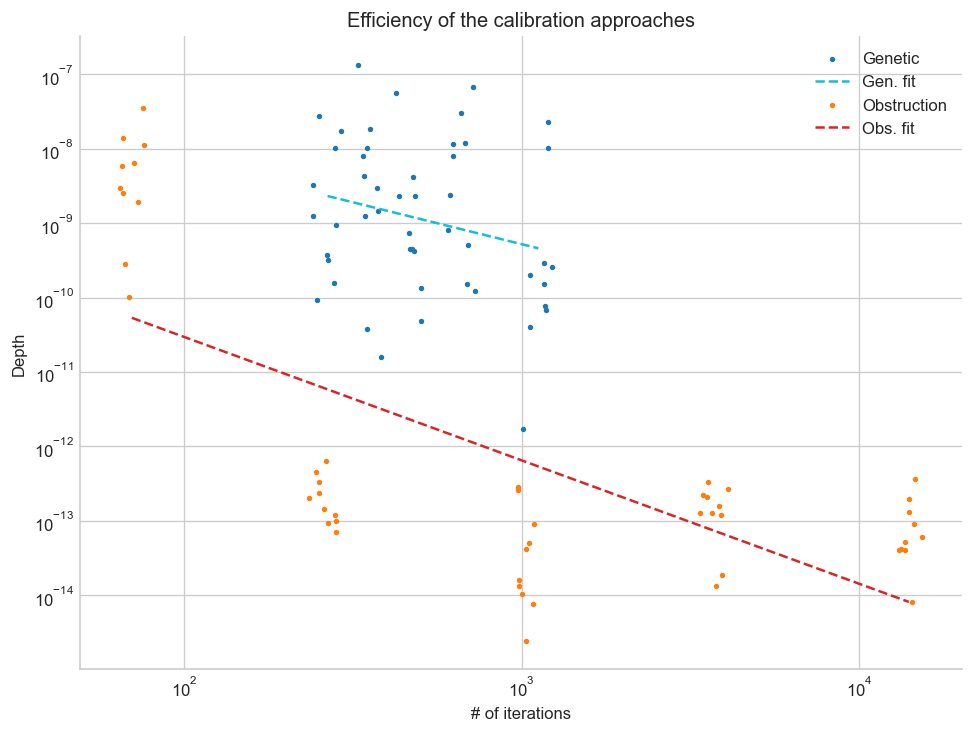

,method,gamma,bright_mean (ph),|depth| mean,|depth| median,depth std
0,Trial & Error (genetic),0.0 nm,3.099720e+13,1.677098e-11,1.535623e-11,2.389986e-11
1,Obstruction,0.0 nm,3.099720e+13,2.812081e-13,4.677841e-13,8.317840e-12


In [7]:
# Compare calibration approaches vs measurement count
# This uses the analysis.calibration.compare_approaches function, which sweeps
# genetic (Trial & Error) and obstruction methods to see depth vs number of measurements.

# Keep n modest for notebook runtime; increase for higher fidelity.
compare_approaches(ctx=build_base_context(monochromatic=True), β=0.85, n=2000, figsize=(8, 6), save_as=str(save_dir))

# Optional: summarize previously run single-shot metrics (if RUN_* sections were executed)
if results:
    table_rows = []
    for item in results:
        if "depth_mean" in item:
            table_rows.append({
                "method": item["method"],
                "gamma": str(item.get("gamma")),
                "bright_mean (ph)": item["bright_mean"],
                "|depth| mean": float(np.mean(np.abs(item["depth_mean"]))),
                "|depth| median": float(np.mean(np.abs(item["depth_median"]))),
                "depth std": float(np.mean(item["depth_std"])),
            })
        else:
            table_rows.append({
                "method": item.get("method", "ML"),
                "gamma": "synthetic",
                "bright_mean (ph)": np.nan,
                "|depth| mean": np.nan,
                "|depth| median": np.nan,
                "depth std": np.nan,
                "phase MSE (rad^2)": item.get("phase_mse"),
            })
    df = pd.DataFrame(table_rows)
    display(df)
else:
    print("No single-run metrics collected; run the sections above if needed.")